In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [11]:
input_dim = 28 * 28
hidden_dim = 128
latent_dim = 20
batch_size = 128
epochs = 10
learning_rate = 1e-3


In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [13]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [14]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )
    return recon_loss + kl_loss


In [15]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [16]:
model.train()

for epoch in range(epochs):
    total_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, input_dim).to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/10] - Loss: 192.2317
Epoch [2/10] - Loss: 137.4506
Epoch [3/10] - Loss: 125.9935
Epoch [4/10] - Loss: 120.8184
Epoch [5/10] - Loss: 117.6847
Epoch [6/10] - Loss: 115.7706
Epoch [7/10] - Loss: 114.4639
Epoch [8/10] - Loss: 113.4137
Epoch [9/10] - Loss: 112.6613
Epoch [10/10] - Loss: 112.0909


In [17]:
model.eval()

with torch.no_grad():
    images, _ = next(iter(train_loader))
    images = images.to(device)

    # Original
    original_image = images[0].view(28, 28).cpu().numpy()

    # Reconstructed
    recon_images, _, _ = model(images.view(-1, input_dim))
    reconstructed_image = recon_images[0].view(28, 28).cpu().numpy()

    # Generated
    z = torch.randn(1, latent_dim).to(device)
    generated_image = model.decode(z).view(28, 28).cpu().numpy()


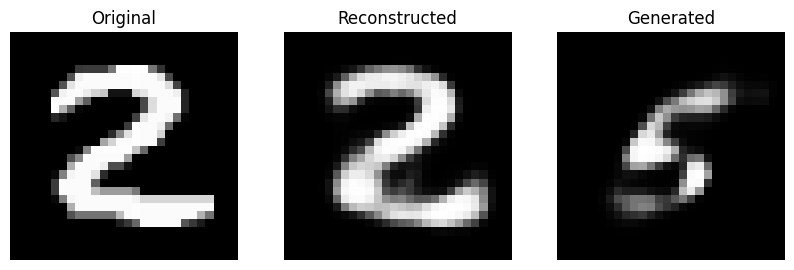

In [18]:
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Plot the reconstructed image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

# Plot the generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_image, cmap='gray')
plt.title('Generated')
plt.axis('off')

plt.show()
